# CLIP

## Instalar de librerías

In [2]:
%%capture
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

## Importar de librerías

In [3]:
import numpy as np
import clip
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from google.colab import drive

In [4]:
drive.mount('/content/drive/', force_remount=True)
BASE_FOLDER = '/content/drive/My Drive/Colab/CLIP/'
os.chdir(BASE_FOLDER)

DATASET_PATH = os.path.join(BASE_FOLDER, 'datasets')

Mounted at /content/drive/


## Cargar el modelo

In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=DEVICE)
if DEVICE == "cuda":
  model.cuda().eval();
else:
  model.cpu().eval();

## Preprocesamiento


### Imágenes

In [7]:
print("Resolución de las imágenes:", model.visual.input_resolution)

Resolución de las imágenes: 224


In [8]:
preprocess_clip

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x792f8aac85e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### Textos

In [9]:
print("Longitud del contexto:", model.context_length)

Longitud del contexto: 77


In [10]:
clip.tokenize("Hola mundo!")

tensor([[49406, 28724, 20990,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Clasificador zero-shot

In [11]:
def preprocess_texts(dataset):
  text_descriptions = [f"This is a photo of a {label}" for label in dataset.classes]
  text_tokens = clip.tokenize(text_descriptions).to(DEVICE)
  return text_tokens

In [12]:
def preprocess_images(dataset, indexes):
  images = []
  labels = []
  original_images = []

  for idx in indexes:
    image, label = dataset[idx]
    label_name = dataset.classes[label]
    original_images.append((image, label_name))

    # Preprocesar la imagen para CLIP
    image_input = preprocess_clip(image).unsqueeze(0).to(DEVICE)
    images.append(image_input)
    labels.append(label)

  return (images, labels, original_images)

In [13]:
def show_example(dataset, index):
  image, label = dataset[index]
  plt.imshow(image)
  plt.title(f"Etiqueta: {dataset.classes[label]}\n Resolución: {image.size}")
  plt.axis('off')
  plt.show()

In [14]:
def show_predictions(dataset, original_images, predictions):
  # Mostrar las imágenes con sus predicciones
  plt.figure(figsize=(15, 5))
  for i in range(len(original_images)):
    image, label_name = original_images[i]
    predicted_class = dataset.classes[predictions[i].argmax()]

    # Mostrar la imagen
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Etiqueta real: {label_name}\nPredicción: {predicted_class}")
    plt.axis('off')
  plt.show()

In [15]:
def load_torch_dataset(dataset_library, dataset_path, dataset_folder):
  # Ruta específica donde el dataset almacena sus archivos
  dataset_folder = os.path.join(dataset_path, dataset_folder)

  # Ruta del archivo .tar.gz descargado
  dataset_tar = os.path.join(dataset_path, dataset_folder + '.tar.gz')

  # Verificar si el dataset ya está descargado
  if not os.path.exists(dataset_folder):
      print("Descargando dataset...")
      dataset = dataset_library(root=dataset_path, transform=None, download=True)
      print("Descarga completa.")

      # Después de la descarga, eliminar el archivo .tar.gz
      if os.path.exists(dataset_tar):
          os.remove(dataset_tar)
          print(f"Archivo {dataset_tar} eliminado.")
  else:
      print("El dataset ya está descargado.")
      dataset = dataset_library(root=dataset_path, transform=None, download=False)

  return dataset

### CIFAR100

In [16]:
from torchvision.datasets import CIFAR100
cifar100 = load_torch_dataset(CIFAR100, DATASET_PATH, 'cifar-100-python')

El dataset ya está descargado.


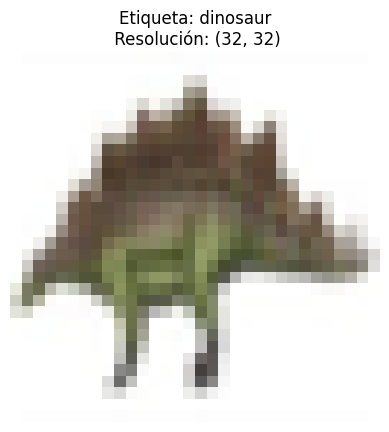

In [17]:
show_example(cifar100, 1)

In [18]:
# Preparar las descripciones de texto y tokenizarlas
text_tokens = preprocess_texts(cifar100)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

print("Longitud del contexto:", text_tokens[0].shape)
print("Vectores de textos:", text_features[:3])
print("Tamaño del espacio vectorial para el texto:", text_features[0].shape)

Longitud del contexto: torch.Size([77])
Vectores de textos: tensor([[-0.0048,  0.0591, -0.0039,  ..., -0.0234, -0.0152, -0.0048],
        [-0.0091, -0.0048,  0.0157,  ...,  0.0344,  0.0006,  0.0177],
        [ 0.0054,  0.0194, -0.0326,  ..., -0.0533, -0.0014, -0.0190]])
Tamaño del espacio vectorial para el texto: torch.Size([512])


In [19]:
# Seleccionar 3 índices aleatorios
indexes = random.sample(range(len(cifar100)), 3)

images, labels, original_images = preprocess_images(cifar100, indexes)

# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

with torch.no_grad():
  image_features = model.encode_image(image_inputs).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)

print("Resolución de las imágenes:", image_inputs[0].shape)
print("Tamaño del espacio vectorial para las imágenes:", image_features[0].shape)

Resolución de las imágenes: torch.Size([3, 224, 224])
Tamaño del espacio vectorial para las imágenes: torch.Size([512])


In [20]:
with torch.no_grad():
    # Calcular similitudes manualmente
    similarities = image_features @ text_features.T
    predictions = similarities.softmax(dim=-1).cpu().numpy()

print("Formato de predicciones:", predictions.shape)
print("Probabilidad acumulada:", predictions[0].sum())

Formato de predicciones: (3, 100)
Probabilidad acumulada: 1.0


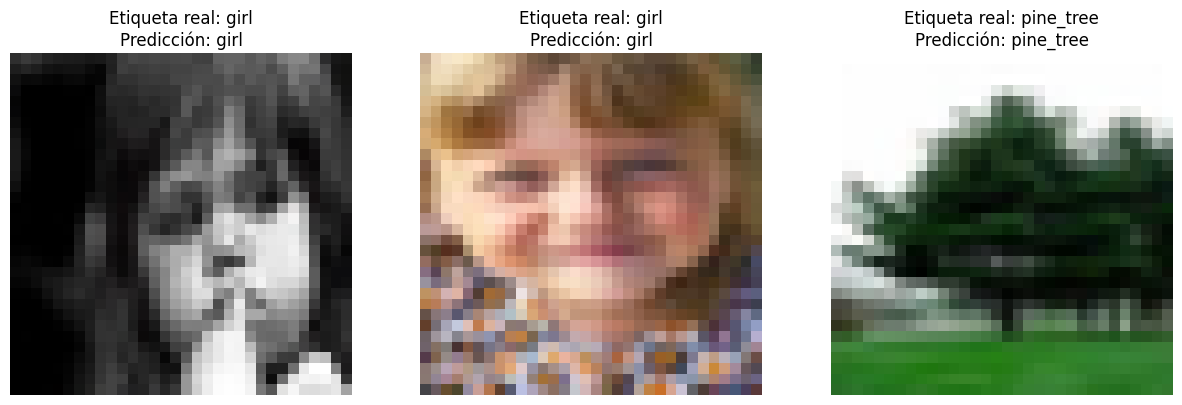

In [21]:
show_predictions(cifar100, original_images, predictions)

### STL10

In [22]:
from torchvision.datasets import STL10

In [23]:
# Cargar el conjunto de datos STL10 sin transformaciones
stl10 = load_torch_dataset(STL10, DATASET_PATH, 'stl10_binary')

El dataset ya está descargado.


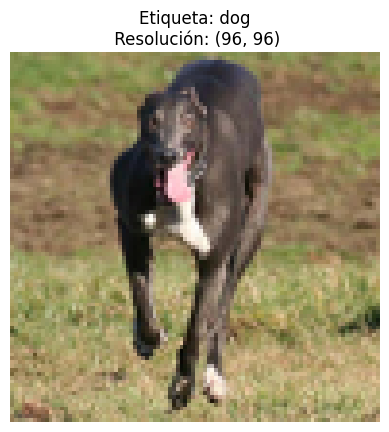

In [24]:
show_example(stl10, 1)

In [25]:
text_tokens = preprocess_texts(stl10)

In [26]:
# Seleccionar 3 índices aleatorios
indexes = random.sample(range(len(stl10)), 3)

images, labels, original_images = preprocess_images(stl10, indexes)

# Concatenar las imágenes en un solo tensor
image_inputs = torch.cat(images, dim=0)

In [27]:
with torch.no_grad():
    # Calcular logits y obtener probabilidades
    logits_per_image, _ = model(image_inputs, text_tokens)
    predictions = logits_per_image.softmax(dim=-1).cpu().numpy()

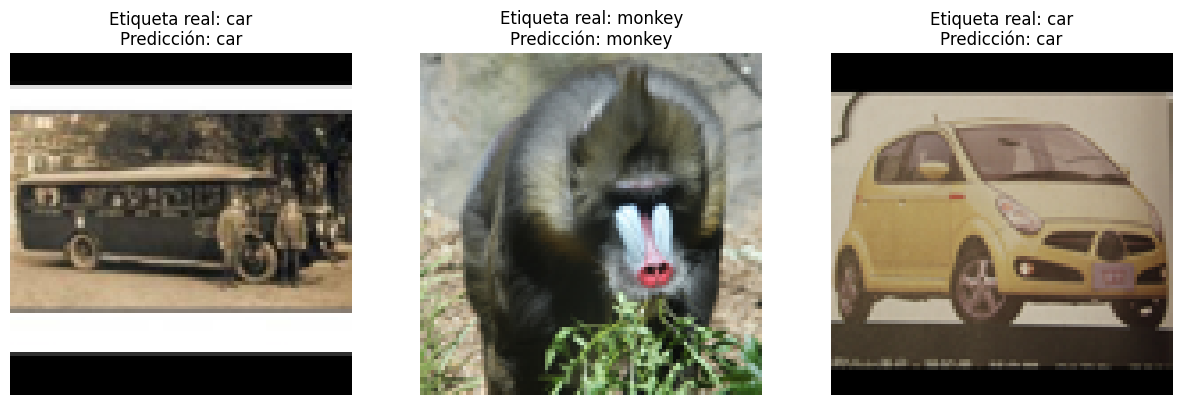

In [28]:
show_predictions(stl10, original_images, predictions)

## Buscar objetos



In [29]:
!wget -P "$DATASET_PATH" https://github.com/theviderlab/computer_vision/raw/main/notebooks/clip/hidden-objects.jpg

--2024-09-23 14:31:09--  https://github.com/theviderlab/computer_vision/raw/main/notebooks/clip/hidden-objects.jpg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/theviderlab/computer_vision/main/notebooks/clip/hidden-objects.jpg [following]
--2024-09-23 14:31:10--  https://raw.githubusercontent.com/theviderlab/computer_vision/main/notebooks/clip/hidden-objects.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502528 (491K) [image/jpeg]
Saving to: ‘/content/drive/My Drive/Colab/CLIP/datasets/hidden-objects.jpg.3’

hidden-objects.jpg. 100%[===================>] 490.75K  2.36MB/s    in 0.2s   

In [30]:
image_path = os.path.join(DATASET_PATH, 'hidden-objects.jpg')
image = Image.open(image_path)

width, height = image.size
print(image.size)

(1920, 1080)


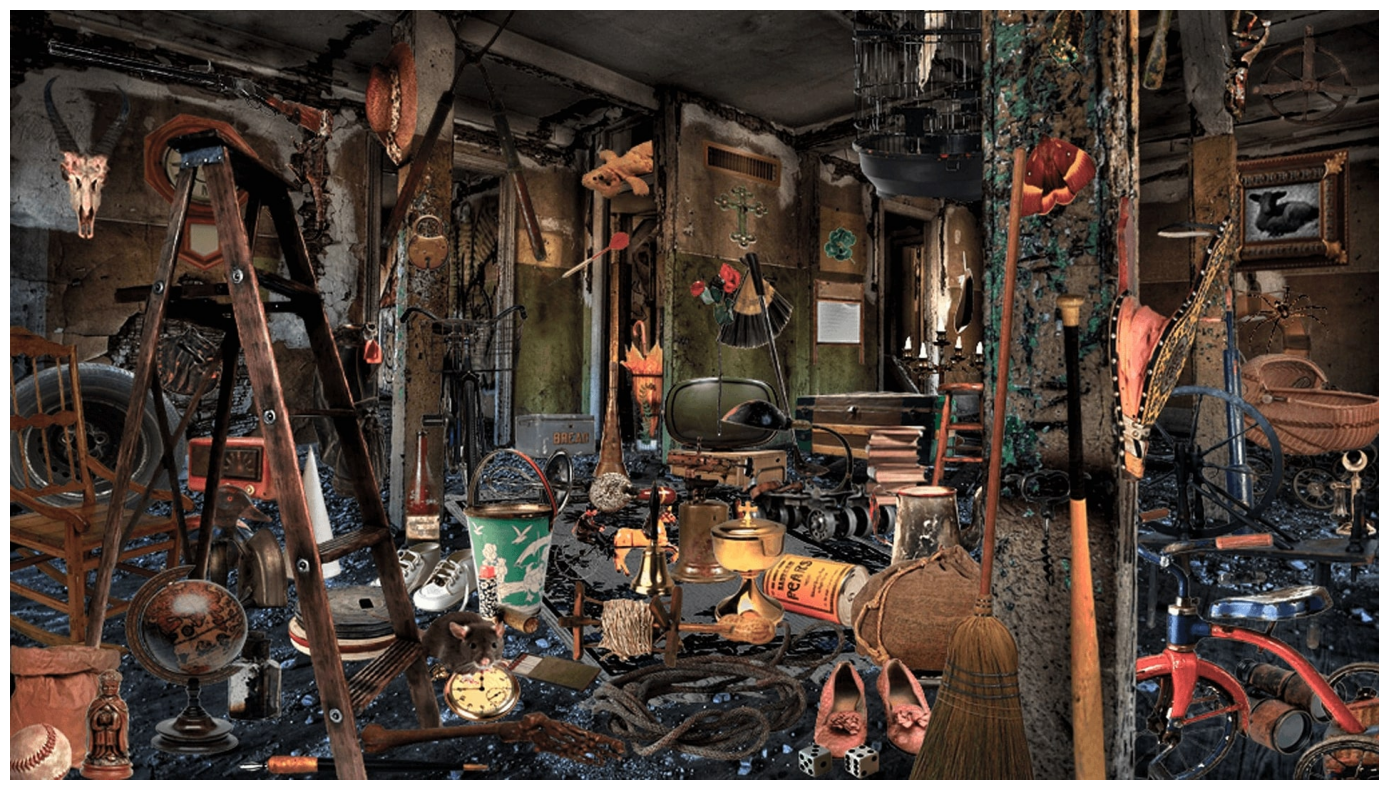

In [31]:
plt.figure(figsize=(20, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [32]:
def get_region(x, y, patch_dim, window, image):
  left = x * patch_dim
  upper = y * patch_dim
  right = left + window * patch_dim
  lower = upper + window * patch_dim

  # Extraer la región de la imagen
  region = image.crop((left, upper, right, lower))

  return region

In [33]:
# Definir el tamaño de los parches
patch_dim = 64

# Calcular el número de parches en cada dimensión
num_patches_x = width // patch_dim
num_patches_y = height // patch_dim

# Definir la ventana
window = 3

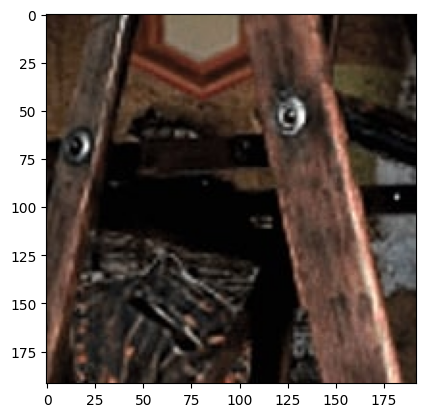

In [34]:
region = get_region(3, 5, patch_dim, window, image)
plt.imshow(region)
plt.show()

In [35]:
# Preparar el texto (en inglés para mejores resultados)
text_prompt = "image of a spider"
text_tokens = clip.tokenize([text_prompt]).to(DEVICE)

In [36]:
# Matriz para almacenar las probabilidades
pred_matrix = np.zeros((num_patches_x - window + 1, num_patches_y - window + 1))
pred_matrix.shape

(28, 14)

In [37]:
# Recorrer la imagen con una ventana deslizante
for x in range(pred_matrix.shape[0]):
    for y in range(pred_matrix.shape[1]):

        # Extraer la región de la imagen
        region = get_region(x, y, patch_dim, window, image)

        # Preprocesar la región para CLIP
        image_input = preprocess_clip(region).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            # Calcular logits y obtener la similitud directamente
            logits_per_image, _ = model(image_input, text_tokens)
            similarity = logits_per_image.squeeze().cpu().item()

        # Almacenar la similitud en la matriz
        pred_matrix[x, y] = similarity

In [38]:
# Normalizar el mapa de probabilidades entre 0 y 1
prediction = (pred_matrix - pred_matrix.min()) / (pred_matrix.max() - pred_matrix.min())
prediction[prediction < 0.8] = 0.1

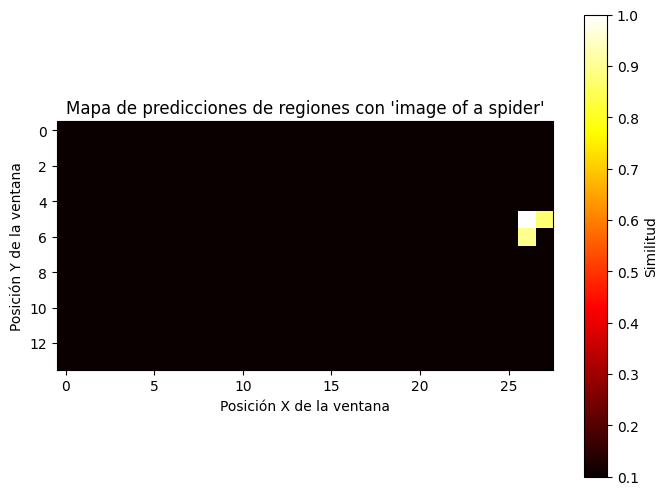

In [39]:
# Mostrar la matriz de probabilidades como una imagen
plt.figure(figsize=(8, 6))
plt.imshow(prediction.T, cmap='hot', interpolation='nearest')
plt.colorbar(label="Similitud")
plt.title(f"Mapa de predicciones de regiones con '{text_prompt}'")
plt.xlabel('Posición X de la ventana')
plt.ylabel('Posición Y de la ventana')
plt.show()

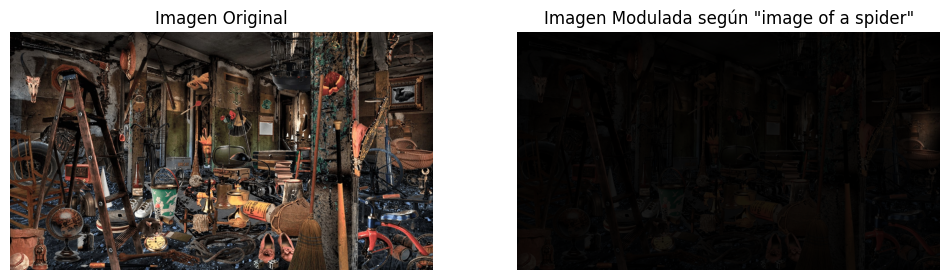

In [40]:
# Redimensionar el mapa de probabilidades al tamaño de la imagen
from scipy.ndimage import zoom

# Calcular el factor de ampliación
zoom_factor_x = width / prediction.shape[0]
zoom_factor_y = height / prediction.shape[1]

# Ampliar el mapa de probabilidades
prediction_map = zoom(prediction, (zoom_factor_x, zoom_factor_y), order=1)
prediction_map = prediction_map[:width, :height]
prediction_map = np.stack([prediction_map.T]*3, axis=-1)

# Modificar la intensidad de la imagen original
image_modulated = np.array(image)
image_modulated = image_modulated.astype(np.float32) * prediction_map
image_modulated = np.clip(image_modulated, 0, 255).astype(np.uint8)
image_modulated = Image.fromarray(image_modulated)

# Mostrar la imagen original y la imagen modulada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_modulated)
plt.title(f'Imagen Modulada según "{text_prompt}"')
plt.axis('off')

plt.show()

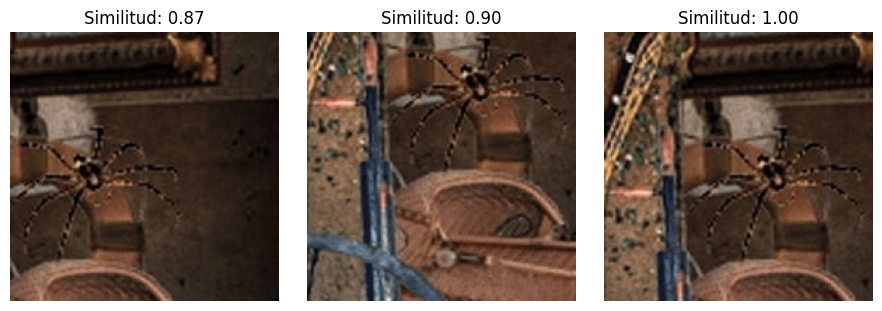

In [41]:
num_top_patches = 3

flatten_patches = prediction.flatten()
sorted_patches = np.argsort(flatten_patches)
top_patches = sorted_patches[-num_top_patches:]
coordinates = np.unravel_index(top_patches, prediction.shape)

# Extraer y mostrar los parches correspondientes
plt.figure(figsize=(15, 6))
for idx in range(num_top_patches):
    # Extraer la región de la imagen
    x = coordinates[0][idx]
    y = coordinates[1][idx]
    region = get_region(x, y, patch_dim, window, image)

    # Mostrar el parche
    plt.subplot(2, 5, idx + 1)
    plt.imshow(region)
    plt.title(f"Similitud: {prediction[x, y]:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Fine-tuning

### Instalar Kaggle

In [42]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


### Descargar dataset

In [43]:
# Definir las variables necesarias
KAGGLE_USER = "kursatkomurcu"
KAGGLE_DATASET = "satellite-image-caption-change-detection"
dataset_origin = f"{KAGGLE_USER}/{KAGGLE_DATASET}"
dataset_folder = os.path.join(DATASET_PATH, KAGGLE_DATASET.replace('-', '_'))
dataset_zip = os.path.join(DATASET_PATH, KAGGLE_DATASET + '.zip')
kaggle_json_path = os.path.join(DATASET_PATH, 'kaggle.json')  # Corregido el nombre

# Verificar que el archivo kaggle.json existe
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError(f"El archivo {kaggle_json_path} no existe. Por favor, colócalo en esa ubicación.")

# Verificar si el dataset ya está descargado
if not os.path.exists(dataset_folder):

  # Descargar el dataset
  if not os.path.exists(dataset_zip):
    print("El dataset no está descargado. Procediendo a descargarlo...")

    # Configurar las credenciales de Kaggle
    !mkdir -p ~/.kaggle
    !cp "{kaggle_json_path}" ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d "{dataset_origin}" -p "{DATASET_PATH}"

  # Eliminar el archivo comprimido
  if os.path.exists(dataset_zip):
    # Descomprimir el archivo
    !unzip -o "{dataset_zip}" -d "{DATASET_PATH}" > /dev/null

    os.remove(dataset_zip)
    print(f"Archivo {dataset_zip} eliminado.")
else:
  print("El dataset ya está descargado.")

El dataset ya está descargado.


In [44]:
# from google.colab import files

# from torchvision import transforms

# from transformers import CLIPProcessor, CLIPModel

In [45]:
dataset_names = [['CLCD','time1'], ['DSIFN','t1'], ['LEVIR-CD','A'], ['S2Looking','Image1']]

caption_path = os.path.join(dataset_folder, 'captions')
caption_train_path = os.path.join(caption_path, 'train')
caption_val_path = os.path.join(caption_path, 'val')

In [46]:
dataframes = []
for dataset_i in dataset_names:
    # Construir la ruta al archivo CSV
    csv_path = os.path.join(caption_train_path, 'train_' + dataset_i[0] + '.csv')
    # Leer el CSV en un DataFrame
    captions_df = pd.read_csv(csv_path)
    captions_df['dataset'] = dataset_i[0]
    captions_df['subfolder'] = dataset_i[1]
    # Añadir el DataFrame a la lista
    dataframes.append(captions_df)

# Concatenar todos los DataFrames en uno solo
captions_train_df = pd.concat(dataframes, ignore_index=True)

captions_train_df['img_path'] = dataset_folder + '/' + captions_train_df['dataset'] + '/train/' + captions_train_df['subfolder'] + '/' + captions_train_df['img']

captions_train_df.head()

img  change                                           caption1  \
0  00000.png       1  The satellite image depicts a rural area with ...   
1  00001.png       1  The satellite image depicts a rural area with ...   
2  00002.png       1  The satellite image depicts a rural landscape ...   
3  00003.png       0  The satellite image depicts a rural landscape ...   
4  00004.png       1  The satellite image depicts a rural village su...   

                                            caption2 dataset subfolder  \
0  The satellite image shows a village surrounded...    CLCD     time1   
1  The satellite image shows a rural area with pa...    CLCD     time1   
2  The satellite image depicts a rural area with ...    CLCD     time1   
3  The satellite image depicts a rural area with ...    CLCD     time1   
4  The satellite image depicts a rural landscape,...    CLCD     time1   

                                            img_path  
0  /content/drive/My Drive/Colab/CLIP/datasets/sa...  
1  /content/drive/My Drive/Colab/CLIP/datasets/sa...  
2  /content/drive/My Drive/Colab/CLIP/datasets/sa...  
3  /content/drive/My Drive/Colab/CLIP/datasets/sa...  
4  /content/drive/My Drive/Colab/CLIP/datasets/sa...

In [47]:
text_encoded = clip.tokenize(captions_train_df['caption1'][0], truncate=False)

RuntimeError: Input The satellite image depicts a rural area with several distinct features. The presence of the water body suggests a natural landscape, potentially used for irrigation or as a source of drinking water for the nearby population. The clustered buildings with dark roofs indicate human habitation and possibly agricultural activity, as the dark roofs could be indicative of thatched or tiled roofing materials commonly found in rural settings. The road provides connectivity to the village, allowing for the transport of goods and people. The surrounding green areas suggest fertile land, which could be used for farming. Overall, this image portrays a self-sustaining rural community with a balance between human settlement and natural environment. is too long for context length 77

In [48]:
captions_train_df['splitted_captions'] = captions_train_df['caption1'].str.split(pat='.') + \
                                         captions_train_df['caption2'].str.split(pat='.')
splitted_captions_train_df = captions_train_df.explode('splitted_captions').reset_index(drop=True)
splitted_captions_train_df = splitted_captions_train_df.loc[:,['img_path', 'splitted_captions']]
splitted_captions_train_df = splitted_captions_train_df.drop_duplicates()

In [49]:
img_paths_train = splitted_captions_train_df['img_path'].to_numpy()
captions_train = splitted_captions_train_df['splitted_captions'].to_numpy()

In [50]:
if DEVICE == "gpu":
  model.cuda().train();
else:
  model.cpu().train();

In [ ]:
# Load the CLIP model and processor
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# Load pre-trained CLIP model
# model, preprocess = clip.load("ViT-B/32", device=DEVICE, jit=False)

In [ ]:
# Preprocessing pipeline (similar to CLIP's preprocessing)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224 (standard for ViT models)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
# ])

In [51]:
class ImageTitleDataset(Dataset):
    def __init__(self, img_paths, captions, transform=None):
        self.image_paths = img_paths
        self.captions = captions
        self.transform = transform
        self.tokenized_captions = clip.tokenize(captions, truncate=True)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Open image and ensure it's RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations
        caption = self.tokenized_captions[idx]
        return image, caption

In [52]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

In [53]:
# Create the custom dataset that pairs images with their titles
dataset = ImageTitleDataset(img_paths_train, captions_train, transform=preprocess_clip)

# Use a DataLoader to load images in batches to save memory
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [54]:
# if DEVICE == "cpu":
#     model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [ ]:
# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    # pbar = train_dataloader
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch

        images = images.to(DEVICE)
        texts = texts.to(DEVICE)

        print(images.shape)
        print(texts.shape)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=DEVICE)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if DEVICE == "cpu":
            optimizer.step()
        else :
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  0%|          | 0/1330 [00:00<?, ?it/s]

torch.Size([128, 3, 224, 224])
torch.Size([128, 77])


In [ ]:
print(images.dtype)

In [ ]:
# Guardar los pesos del modelo después del entrenamiento
save_path = '/content/modelo_entrenado.pth'
torch.save(model.state_dict(), save_path)
print(f"Pesos del modelo guardados en {save_path}")